In [211]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input, MultiHeadAttention, Dropout, Concatenate
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [212]:
data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
print(data.head()) 

         Ngay  mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
0  01/01/2008        120        498.815         259.499               0.0   
1  02/01/2008        117        470.866         518.755               0.0   
2  03/01/2008        139        423.816         615.242               0.0   
3  04/01/2008        166        496.882         902.982               0.0   
4  05/01/2008        179        501.232        1072.970               0.0   

   chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
0               0.0        23.230         90.200  
1               0.0        26.239        213.791  
2               0.0        24.000        175.000  
3               0.0        11.000        164.000  
4               0.0        24.000        177.000  


In [213]:
data['Ngay'] = pd.to_datetime(data['Ngay'], format='%d/%m/%Y')
data.set_index('Ngay', inplace=True)
print(data.head()) 

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
2008-01-01        120        498.815         259.499               0.0   
2008-01-02        117        470.866         518.755               0.0   
2008-01-03        139        423.816         615.242               0.0   
2008-01-04        166        496.882         902.982               0.0   
2008-01-05        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
2008-01-01               0.0        23.230         90.200  
2008-01-02               0.0        26.239        213.791  
2008-01-03               0.0        24.000        175.000  
2008-01-04               0.0        11.000        164.000  
2008-01-05               0.0        24.000        177.000  


In [214]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
print(data_scaled)

[[0.08651911 0.04639671 0.09251301 ... 0.         0.1056379  0.16986817]
 [0.08350101 0.04373844 0.18493939 ... 0.         0.1065453  0.40261959]
 [0.1056338  0.03926346 0.21933761 ... 0.         0.10587011 0.32956685]
 ...
 [0.05030181 0.0244436  0.16898396 ... 0.0771473  0.12747699 0.16129944]
 [0.04627767 0.0505992  0.12299465 ... 0.09429296 0.13279774 0.14287571]
 [0.04325956 0.07618414 0.13568271 ... 0.09247136 0.15019965 0.0433145 ]]


In [215]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # 'mucNuocHN' là cột đầu tiên
    return np.array(sequences), np.array(targets)

In [216]:
sequence_length = 2 # Sử dụng 7 ngày trước để dự báo ngày tiếp theo
X, y = create_sequences(data_scaled, sequence_length)


In [217]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [218]:
# Thay đổi hình dạng dữ liệu đầu vào cho LSTM (số mẫu, bước thời gian, số đặc trưng)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [219]:
# Xây dựng mô hình
input_layer = Input(shape=(sequence_length, X_train.shape[2]))

In [220]:
# LSTM lớp ẩn
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Lớp Attention
attention = Attention()([lstm_out, lstm_out])
attention_output = tf.reduce_sum(attention, axis=1)

# Lớp đầu ra
output = Dense(1)(attention_output)

In [221]:
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [222]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 2, 7)]               0         []                            
                                                                                                  
 lstm_11 (LSTM)              (None, 2, 64)                18432     ['input_11[0][0]']            
                                                                                                  
 attention_7 (Attention)     (None, 2, 64)                0         ['lstm_11[0][0]',             
                                                                     'lstm_11[0][0]']             
                                                                                                  
 tf.math.reduce_sum_9 (TFOp  (None, 64)                   0         ['attention_7[0][0]']   

In [223]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
52/52 [==============================] - 4s 20ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 2/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 3/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 9.3250e-04 - val_loss: 0.0015
Epoch 5/100
52/52 [==============================] - 1s 11ms/step - loss: 8.4207e-04 - val_loss: 0.0014
Epoch 6/100
52/52 [==============================] - 0s 6ms/step - loss: 8.3546e-04 - val_loss: 0.0016
Epoch 7/100
52/52 [==============================] - 0s 6ms/step - loss: 7.7287e-04 - val_loss: 0.0012
Epoch 8/100
52/52 [==============================] - 0s 8ms/step - loss: 8.0110e-04 - val_loss: 0.0018
Epoch 9/100
52/52 [==============================] - 1s 12ms/step - loss: 8.4084e-04 - val_loss: 0.0022
Epoch 10/100
52/52 [==============================] - 0s 8ms/step - loss: 8.5720e-

In [224]:
def nse(y_true, y_pred):
    return 1 - sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2)

In [225]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

# Tính NSE
nse_value = nse(y_test.flatten(), y_pred.flatten())
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 1s 4ms/step
R² (R-squared): 0.9747176009322673
Nash-Sutcliffe Efficiency (NSE): 0.9747176009322673
Mean Absolute Error (MAE): 0.014290770302271572
Root Mean Squared Error (RMSE): 0.01940308983261586


In [226]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

16/16 [==============================] - 0s 4ms/step - loss: 3.7648e-04
Test Loss: 0.0003764799330383539


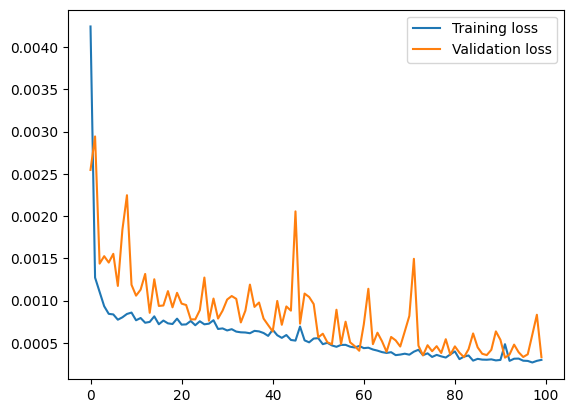

In [227]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [228]:
data_test = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2.csv')  # Thay 'your_test_file.csv' bằng đường dẫn file test của bạn
data_test['Ngay'] = pd.to_datetime(data_test['Ngay'], format='%d/%m/%Y')
data_test.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_test)

In [229]:
# Chuẩn hóa dữ liệu test bằng scaler đã huấn luyện
data_test_scaled = scaler.transform(data_test)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled, sequence_length)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [230]:
predictions_new = model.predict(X_test_new)

# Chuyển đổi giá trị dự đoán và thực tế về mực nước ban đầu
# predictions_new_original = scaler.inverse_transform(np.concatenate((predictions_new, np.zeros((predictions_new.shape[0], data_test_scaled.shape[1] - 1))), axis=1))[:, 0]
# y_test_new_original = scaler.inverse_transform(np.concatenate((y_test_new.reshape(-1, 1), np.zeros((y_test_new.shape[0], data_test_scaled.shape[1] - 1))), axis=1))[:, 0]


23/23 [==============================] - 0s 5ms/step


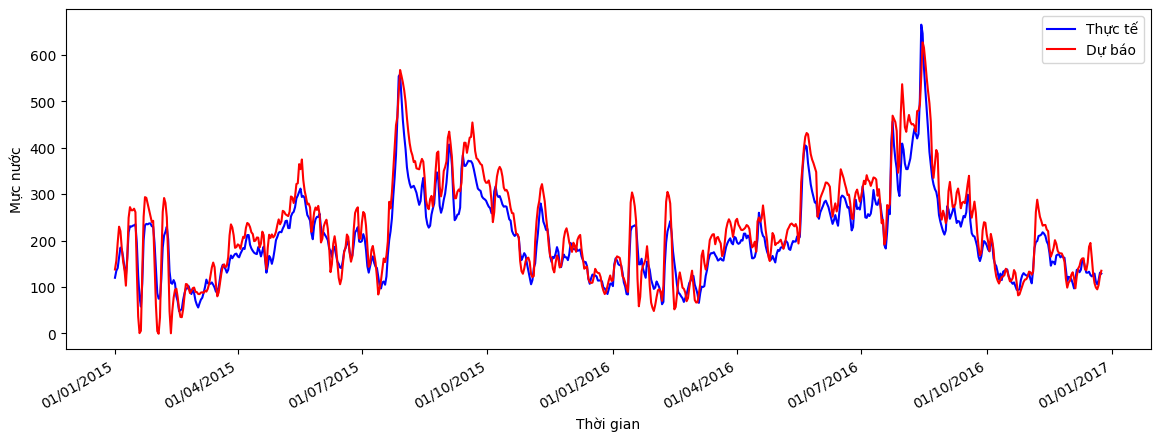

In [231]:
# Đảm bảo các mảng có cùng kích thước
min_length = min(len(data_test.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = data_test.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
